# Better cats and dogs binary classification

Dataset source: [Kaggle: Cat VS Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset/data) 

## Python imports

In [2]:
# Base Python
import os
import time
import random
import warnings
import shutil

# Data processing and modelization
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix  # Avoid duplicate imports
import kagglehub

# Monitoring and visualization
from torchsummary import summary
from PIL import Image

# Various utilities
from utils import (
    plot_confusion_matrix,
    plot_training_metrics,
    show_colored_random_samples,
    get_random_samples,
    plot_score_distribution,
    plot_sensitivity_specificity_vs_thresholds,
    plot_roc_curve,
    save_checkpoint,
    load_nearest_checkpoint,
    remove_corrupted_images
)

# Model export and loading
import onnx
import onnxruntime as ort

## Software versions
```
- Python v3.12.5
```
### Packages

```
- numpy v1.26.4
- cuda v12.1
- torch v2.4.1+cu121
- torchvision v0.19.1+cu121
- onnx v1.16.2
- sklearn v1.5.2
- onnxruntime v1.20.0
```

## Python setup

In [3]:
warnings.filterwarnings('ignore')

## GPU selection

In [4]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    device = 'cuda'
    torch.cuda.get_device_name(0)
    torch.set_default_device(device)
    print(f'CUDA is available. Training on {torch.cuda.get_device_name()}')
else:
    device = 'cpu'
    print('CUDA is not available. Training on CPU')
generator = torch.Generator(device=device)

CUDA is available. Training on NVIDIA GeForce RTX 4070


## Condition reproducibility

Source: [Pytorch](https://pytorch.org/docs/stable/notes/randomness.html)

In [5]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
# Set the environment variable for deterministic behavior
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

if train_on_gpu:
    torch.cuda.manual_seed_all(SEED)

## Dataset download

In [8]:
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
dogs_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Dog")
cats_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Cat")
path

'/home/malo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1'

## Dataset checking

In [6]:
remove_corrupted_images(dogs_path)
remove_corrupted_images(cats_path)

Total images in /home/malo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog: 12469 (after removing 0 corrupted files)
Total images in /home/malo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat: 12490 (after removing 0 corrupted files)


## Dataset volume selection

## Pytorch Dataset initialization 

### Images transformation

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),             # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for color images
])

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
# Dataset params
TOTAL_SAMPLES = 24000
TRAIN_SIZE = 0.875
VAL_SIZE = 0.025
TEST_SIZE = 0.10
BATCH_SIZE = 128 # 256

# Get the required number of samples for each class
dog_images = [os.path.join(dogs_path, img) for img in os.listdir(dogs_path) if img.endswith(".jpg")][:(TOTAL_SAMPLES // 2)]
cat_images = [os.path.join(cats_path, img) for img in os.listdir(cats_path) if img.endswith(".jpg")][:(TOTAL_SAMPLES // 2)]

# Associer les images avec leurs labels
all_images = dog_images + cat_images
all_labels = [0] * len(dog_images) + [1] * len(cat_images)

# Diviser en trois sous-ensembles (train, val, test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=(1 - TRAIN_SIZE), stratify=all_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), stratify=temp_labels, random_state=42
)

# Dataset personnalisé pour gérer les images et leurs labels
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Conserver en couleur (RGB)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label
        
train_dataset = CatDogDataset(train_imgs, train_labels, transform=train_transforms)
val_dataset = CatDogDataset(val_imgs, val_labels, transform=data_transform)
test_dataset = CatDogDataset(test_imgs, test_labels, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=generator)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 21000
Number of validation samples: 600
Number of test samples: 2400


## Sample displaying

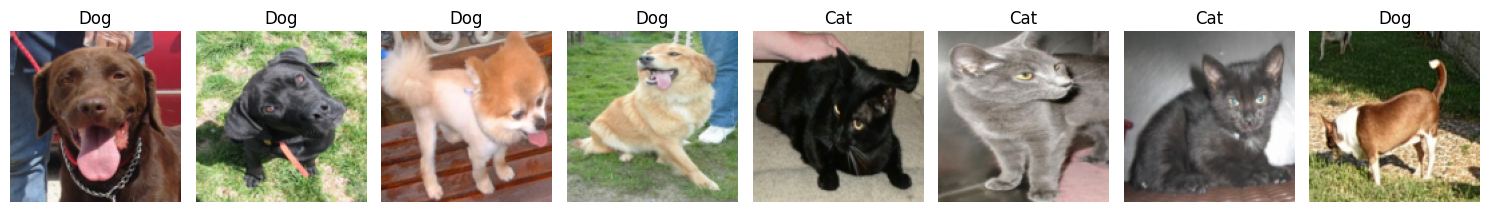

In [13]:
classes = ["Dog", "Cat"]
show_colored_random_samples(train_dataset, classes)

## Model definition

In [14]:
class CNNBinaryClassifier(nn.Module):
    def __init__(self, input_shape=(3, 128, 128)):
        super(CNNBinaryClassifier, self).__init__()
        
        # Convolutional Block 1
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)  # BatchNorm after last conv in block
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling by 2

        # Convolutional Block 2
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 4 (with an additional convolutional layer)
        self.conv4_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Extra layer
        self.bnorm4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output (1, 1) spatially for each channel

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bnorm1(x)
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bnorm2(x)
        x = self.pool2(x)

        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bnorm3(x)
        x = self.pool3(x)

        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))  # Additional layer
        x = self.bnorm4(x)
        x = self.pool4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # Flatten for fully connected layers

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Binary classification output

        return x

summary(CNNBinaryClassifier().cuda(), input_size = [(3, 128, 128)])

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─BatchNorm2d: 1-3                       64
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            18,496
├─Conv2d: 1-6                            36,928
├─BatchNorm2d: 1-7                       128
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            73,856
├─Conv2d: 1-10                           147,584
├─BatchNorm2d: 1-11                      256
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           295,168
├─Conv2d: 1-14                           590,080
├─Conv2d: 1-15                           590,080
├─BatchNorm2d: 1-16                      512
├─MaxPool2d: 1-17                        --
├─AdaptiveAvgPool2d: 1-18                --
├─Linear: 1-19                           16,448
├─Linear: 1-20                           65
├─Dropout: 1-21             

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─BatchNorm2d: 1-3                       64
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            18,496
├─Conv2d: 1-6                            36,928
├─BatchNorm2d: 1-7                       128
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            73,856
├─Conv2d: 1-10                           147,584
├─BatchNorm2d: 1-11                      256
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           295,168
├─Conv2d: 1-14                           590,080
├─Conv2d: 1-15                           590,080
├─BatchNorm2d: 1-16                      512
├─MaxPool2d: 1-17                        --
├─AdaptiveAvgPool2d: 1-18                --
├─Linear: 1-19                           16,448
├─Linear: 1-20                           65
├─Dropout: 1-21             

## Validation code

In [15]:
def validate_model(model, val_loader, threshold = 0.5):
    """
    Validate the model using a validation data loader and calculate accuracy and confusion matrix.

    Parameters:
    model (torch.nn.Module): The PyTorch model to validate.
    val_loader (torch.utils.data.DataLoader): The validation data loader.
    threshold (float, optional): The threshold to convert probabilities to binary predictions.
                                Defaults to 0.5.

    Returns:
    tuple: A tuple containing the accuracy and confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:    
            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()
                
            outputs = model(images)
            preds = (outputs > threshold).float()

            all_preds.extend(preds.detach().cpu().numpy().flatten())
            all_labels.extend(labels.detach().cpu().numpy().flatten())

    all_preds = np.array(all_preds).astype(int)
    all_labels = np.array(all_labels).astype(int)

    if len(all_preds) != len(all_labels):
        raise ValueError(f"Found input variables with inconsistent numbers of samples: [{len(all_preds)}, {len(all_labels)}]")

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

## Training initialization

In [17]:
# Hyperparamètres
EPOCHS = 2 #250 # 1000
BATCH_SIZE = 256
LEARNING_RATE = 0.001
VALIDATION_EPOCH_INTERVAL = 5
CHECKPOINT_EPOCH_INTERVAL = 200
STARTING_EPOCH = 0
EARLY_STOPPING_ACC_THRESHOLD = 0.95  # Accuracy threshold (example: 90%)
EARLY_STOPPING_PATIENCE = 2    # Number of consecutive validations above the threshold to stop

model = CNNBinaryClassifier(input_shape=(3, 128, 128))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if train_on_gpu:
    model = model.cuda()

## Training loop

Epoch [1/2], Loss: 0.590504, Accuracy: 69.29%, Val accuracy: 72.00%, Epoch time: 64.65s
Epoch [2/2], Loss: 0.656243, Accuracy: 62.37%, Epoch time: 53.39s

Total training time: 119.46s
Average time per epoch: 59.02s


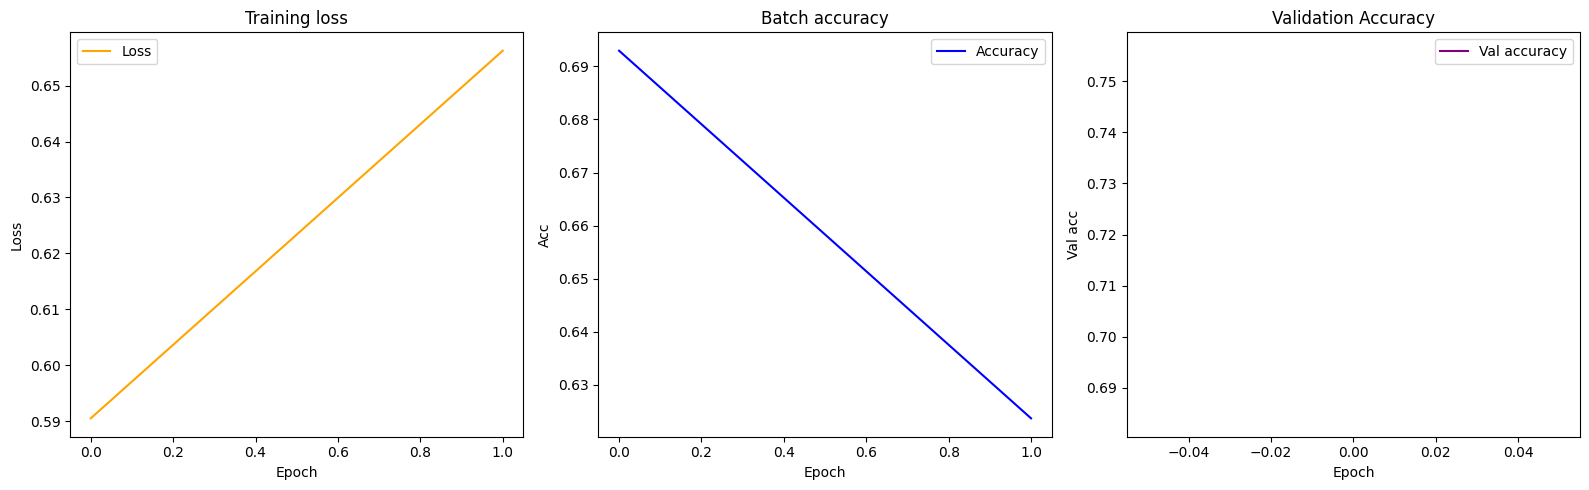

In [18]:
def train_model(model, train_loader, criterion, optimizer, epochs, start_epoch = 0):
    warnings.filterwarnings('ignore')
    model.train()
    losses = []
    accuracies = []
    val_accuracies = []

    # Variables de suivi pour le temps
    epoch_times = []

    # Early stopping tracking variables
    best_val_accuracy = 0
    consecutive_val_success = 0  # Compteur de validations réussies
    
    if start_epoch > 0:
        load_nearest_checkpoint(model, start_epoch)

    # Temps de début d'entraînement
    total_start_time = time.time()
        
    for epoch in range(0, epochs):
        epoch_start_time = time.time()  # Début de l'époque
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.float()
            labels = labels.float().view(-1)

            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)

            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(np.round(all_preds), np.round(all_labels))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # Fin de l'époque et calcul du temps écoulé
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)  # Stockage du temps de chaque époque

        if (epoch) % VALIDATION_EPOCH_INTERVAL == 0:
            acc, _ = validate_model(model, val_loader)
            val_accuracies.append(acc)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc * 100:.2f}%, "
                  f"Val accuracy: {acc * 100:.2f}%, Epoch time: {epoch_time:.2f}s")

            # Early stopping condition
            if acc >= EARLY_STOPPING_ACC_THRESHOLD:
                consecutive_val_success += 1
                if consecutive_val_success >= EARLY_STOPPING_PATIENCE:
                    print(f"Early stopping triggered after {epoch+1} epochs. Validation accuracy {acc * 100:.2f}% "
                          f"exceeded threshold for {EARLY_STOPPING_PATIENCE} consecutive intervals.")
                    break
            else:
                consecutive_val_success = 0
        
        else:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc * 100:.2f}%, "
                  f"Epoch time: {epoch_time:.2f}s")
            

        if (epoch) % CHECKPOINT_EPOCH_INTERVAL == 0 and epoch > 0:
            save_checkpoint(model, epoch, directory="./checkpoints")

    # Temps total d'entraînement
    total_training_time = time.time() - total_start_time
    average_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"\nTotal training time: {total_training_time:.2f}s")
    print(f"Average time per epoch: {average_epoch_time:.2f}s")
                
    plot_training_metrics(losses, accuracies, val_accuracies)

train_model(model, train_loader, criterion, optimizer, EPOCHS, start_epoch=STARTING_EPOCH)

## Export

In [19]:
def export(export_path = './models/cat_or_dog.onnx'):
    warnings.filterwarnings('default')
    if not os.path.exists('./models'):
        os.makedirs('./models')
    
    X, y = get_random_samples(train_dataset, 1)
    input_tensor = X[0].unsqueeze(0).to(device)
    
    torch.onnx.export(model,                      # model being run
                      input_tensor,               # model input (or a tuple for multiple inputs)
                      export_path,                # where to save the model (can be a file or file-like object)
                      input_names = ['input'],    # the model's input names
                      output_names = ['output'])  # the model's output names
    warnings.filterwarnings('ignore')

export()

## Re-loading

In [20]:
warnings.filterwarnings('ignore')

In [21]:
import_path = './models/cat_or_dog.onnx'

onnx_model = onnx.load(import_path)
onnx.checker.check_model(onnx_model)

## Testing

In [22]:
# Set up the directory for storing false predictions
false_preds_dir = './false_preds'
if os.path.exists(false_preds_dir):
    shutil.rmtree(false_preds_dir)  # Remove existing content
os.makedirs(false_preds_dir)  # Create directory for false predictions

# Define the inverse transformation for RGB images
inverse_transform = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],  # Undo normalization per channel
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    ),
    transforms.ToPILImage()  # Convert back to PIL image in RGB
])

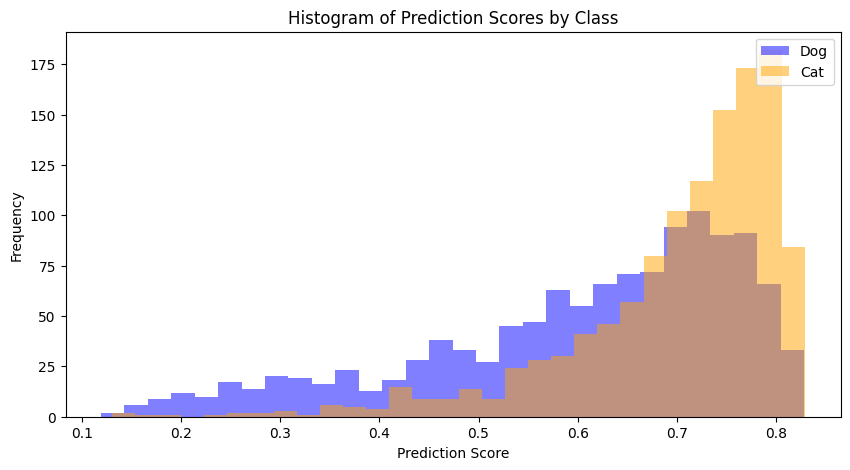

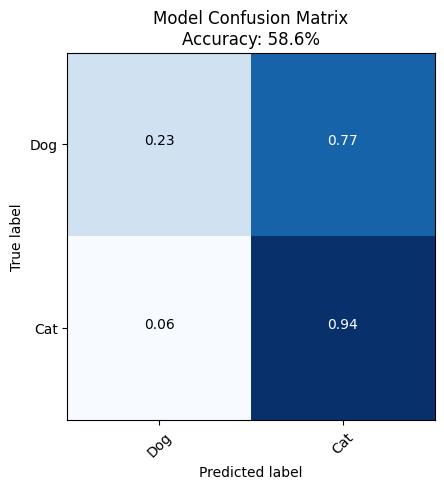

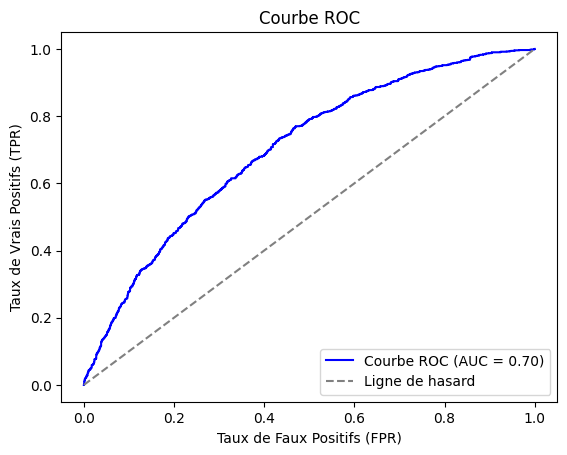

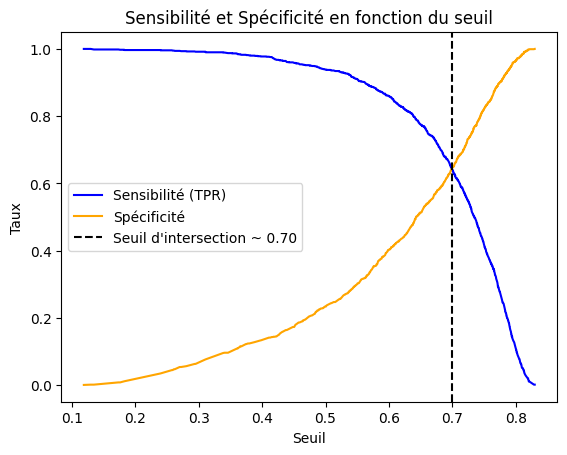

In [23]:
threshold = 0.5

# Store prediction scores and true labels
prediction_scores = []  # To store raw prediction scores (before threshold)
true_labels = []        # To store the true binary labels (0 or 1)

ort_session = ort.InferenceSession(import_path, providers=['CPUExecutionProvider'])

idx = 0
# Iterate over the test loader 
for images, labels in test_loader:
    for image, label in zip(images, labels):
        # Move the image to the CPU and add a batch dimension
        image = image.unsqueeze(0).cpu()

        # Run inference on the image and get raw score
        outputs = ort_session.run(None, {'input': image.numpy()})
        score = outputs[0][0]  # Probability or raw score for 'Cat' class

        # Store the raw prediction score and the true label
        prediction_scores.append(score)
        true_label = label.cpu().detach().numpy().item()
        true_labels.append(true_label)

        is_correct = (score > threshold) == true_label

        if not is_correct:
            # Apply inverse transform to get a PIL Image and save it
            img_pil = inverse_transform(image.squeeze(0))  # Remove batch dimension
            pred_class = classes[int(score > threshold)]
            true_class = classes[true_label]
            
            # Save with a filename that includes the true/predicted classes
            img_pil.save(f"{false_preds_dir}/idx_{idx}_true_{true_class}_pred_{pred_class}.jpeg")
            idx += 1


accuracy = sum((score[0] > threshold) == label for score, label in zip(prediction_scores, true_labels)) / len(prediction_scores)
cm = confusion_matrix(true_labels, [int(score > threshold) for score in prediction_scores], labels=[0, 1])

plot_score_distribution(prediction_scores, true_labels, classes, threshold=threshold)
plot_confusion_matrix(cm, classes=classes, title=f"Model Confusion Matrix\nAccuracy: {accuracy * 100:.1f}%", normalize=True)

new_threshold = plot_sensitivity_specificity_vs_thresholds(thresholds, tpr, fpr)
fpr, tpr, thresholds = plot_roc_curve(true_labels, prediction_scores)

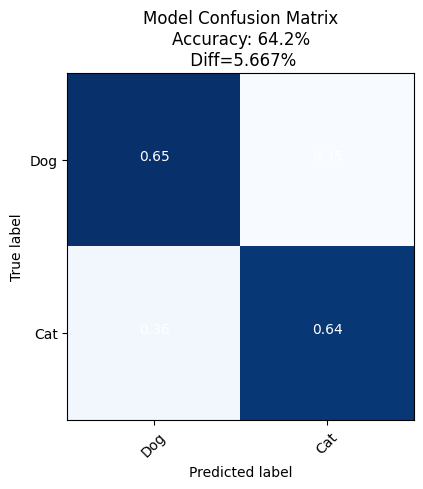

In [24]:
new_threshold = 0.7 # new_threshold

# Store prediction scores and true labels
prediction_scores = []  # To store raw prediction scores (before threshold)
true_labels = []        # To store the true binary labels (0 or 1)

idx = 0

# Iterate over the test loader 
for images, labels in test_loader:
    for image, label in zip(images, labels):
        # Move the image to the CPU and add a batch dimension
        image = image.unsqueeze(0).cpu()

        # Run inference on the image and get raw score
        outputs = ort_session.run(None, {'input': image.numpy()})
        score = outputs[0][0]  # Probability or raw score for 'Cat' class

        # Store the raw prediction score and the true label
        prediction_scores.append(score)
        true_label = label.cpu().detach().numpy().item()
        true_labels.append(true_label)

new_acc = sum((score[0] > new_threshold) == label for score, label in zip(prediction_scores, true_labels)) / len(prediction_scores)
cm = confusion_matrix(true_labels, [int(score > new_threshold) for score in prediction_scores], labels=[0, 1])

diff = abs(accuracy - new_acc)

plot_confusion_matrix(cm, classes=classes, title=f"Model Confusion Matrix\nAccuracy: {new_acc * 100:.1f}%\n Diff={diff * 100:.3f}%", normalize=True)